# **Customer Churn Analysis**

**Author:** Harriet


*This project was created to showcase practical SQL and Python data analysis skills applied to a customer churn scenario in the banking industry*

In [2]:
import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np

**Designing the Dataset**

3 tables need to be created

1. customers

2. accounts

3. transactions

In [3]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [4]:
# Generate customers
num_customers = 100
customer_ids = range(1, num_customers + 1)
names = [f"Customer_{i}" for i in customer_ids]
genders = np.random.choice(['Male', 'Female'], size=num_customers)
ages = np.random.randint(18, 70, size=num_customers)
join_dates = [datetime(2020, 1, 1) + timedelta(days=random.randint(0, 1460)) for _ in customer_ids]


In [5]:
customers_df = pd.DataFrame({
    'customer_id': customer_ids,
    'name': names,
    'gender': genders,
    'age': ages,
    'join_date': join_dates
})

In [6]:
# Generate accounts
account_ids = range(1001, 1001 + num_customers)
account_types = np.random.choice(['Savings', 'Current'], size=num_customers)
open_dates = [join_date + timedelta(days=random.randint(0, 30)) for join_date in join_dates]
close_dates = [date + timedelta(days=random.randint(365, 1095)) if random.random() < 0.3 else None for date in open_dates]

accounts_df = pd.DataFrame({
    'account_id': account_ids,
    'customer_id': customer_ids,
    'account_type': account_types,
    'open_date': open_dates,
    'close_date': close_dates
})

In [7]:
customers_df

,customer_id,name,gender,age,join_date
0,1,Customer_1,Male,35,2023-08-02
1,2,Customer_2,Female,43,2020-08-16
2,3,Customer_3,Male,61,2020-02-21
3,4,Customer_4,Male,51,2021-07-17
4,5,Customer_5,Male,27,2021-05-16
...,...,...,...,...,...
95,96,Customer_96,Female,60,2023-11-10
96,97,Customer_97,Female,46,2023-02-14
97,98,Customer_98,Female,53,2021-03-25
98,99,Customer_99,Female,30,2023-11-03


In [8]:
accounts_df

,account_id,customer_id,account_type,open_date,close_date
0,1001,1,Savings,2023-08-28,NaT
1,1002,2,Savings,2020-09-09,NaT
2,1003,3,Savings,2020-03-16,2022-04-02
3,1004,4,Current,2021-07-18,NaT
4,1005,5,Current,2021-05-23,NaT
...,...,...,...,...,...
95,1096,96,Savings,2023-12-09,NaT
96,1097,97,Current,2023-02-17,2024-06-18
97,1098,98,Savings,2021-04-21,NaT
98,1099,99,Savings,2023-11-23,NaT


In [9]:
# Generate transactions
transactions = []
transaction_id = 1
for account_id, open_date, close_date in zip(account_ids, open_dates, close_dates):
    num_transactions = random.randint(3, 15)
    last_date = close_date or datetime.today()
    for _ in range(num_transactions):
        txn_date = open_date + timedelta(days=random.randint(0, (last_date - open_date).days))
        amount = round(random.uniform(100, 10000), 2)
        txn_type = random.choice(['Deposit', 'Withdrawal'])
        transactions.append([transaction_id, account_id, txn_date, amount, txn_type])
        transaction_id += 1

transactions_df = pd.DataFrame(transactions, columns=[
    'transaction_id', 'account_id', 'transaction_date', 'amount', 'transaction_type'
])

In [10]:
transactions_df

,transaction_id,account_id,transaction_date,amount,transaction_type
0,1,1001,2023-11-19,4250.33,Withdrawal
1,2,1001,2024-05-21,2122.17,Withdrawal
2,3,1001,2024-04-28,2729.58,Deposit
3,4,1002,2024-04-22,3069.97,Withdrawal
4,5,1002,2024-11-26,9363.77,Deposit
...,...,...,...,...,...
887,888,1100,2025-01-17,3790.80,Deposit
888,889,1100,2022-11-06,2309.53,Deposit
889,890,1100,2024-02-03,782.37,Withdrawal
890,891,1100,2023-06-05,7757.92,Withdrawal


In [11]:
customers_df.to_csv('customers.csv', index=False)


In [12]:
accounts_df.to_csv('accounts.csv', index=False)

In [13]:
transactions_df.to_csv('transactions.csv', index=False)

In [15]:
import pandas as pd
import sqlite3

conn = sqlite3.connect(":memory:")

customers_df.to_sql("customers", conn, index=False, if_exists="replace")
accounts_df.to_sql("accounts", conn, index=False, if_exists="replace")
transactions_df.to_sql("transactions", conn, index=False, if_exists="replace")


892

In [16]:
customers_df.head()
accounts_df.head()
transactions_df.head()


,transaction_id,account_id,transaction_date,amount,transaction_type
0,1,1001,2023-11-19,4250.33,Withdrawal
1,2,1001,2024-05-21,2122.17,Withdrawal
2,3,1001,2024-04-28,2729.58,Deposit
3,4,1002,2024-04-22,3069.97,Withdrawal
4,5,1002,2024-11-26,9363.77,Deposit


**ACTIVE CUSTOMERS**

In [33]:
query = """
SELECT
    c.customer_id,
    c.name,
    a.account_id,
    a.close_date
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
WHERE a.close_date IS NULL
"""
result = pd.read_sql_query(query, conn)
result.head()



,customer_id,name,account_id,close_date
0,1,Customer_1,1001,None
1,2,Customer_2,1002,None
2,4,Customer_4,1004,None
3,5,Customer_5,1005,None
4,6,Customer_6,1006,None


### ***Customer Lifetime (Duration in Months)***

In [18]:
query = """ SELECT
    c.customer_id,
    c.name,
    c.join_date,
    COALESCE(a.close_date, DATE('now')) AS end_date,
    ROUND((JULIANDAY(COALESCE(a.close_date, DATE('now'))) - JULIANDAY(c.join_date)) / 30.0, 1) AS lifetime_months
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id;
 """
result = pd.read_sql_query(query, conn)
result


,customer_id,name,join_date,end_date,lifetime_months
0,1,Customer_1,2023-08-02 00:00:00,2025-05-12,21.6
1,2,Customer_2,2020-08-16 00:00:00,2025-05-12,57.7
2,3,Customer_3,2020-02-21 00:00:00,2022-04-02 00:00:00,25.7
3,4,Customer_4,2021-07-17 00:00:00,2025-05-12,46.5
4,5,Customer_5,2021-05-16 00:00:00,2025-05-12,48.6
...,...,...,...,...,...
95,96,Customer_96,2023-11-10 00:00:00,2025-05-12,18.3
96,97,Customer_97,2023-02-14 00:00:00,2024-06-18 00:00:00,16.3
97,98,Customer_98,2021-03-25 00:00:00,2025-05-12,50.3
98,99,Customer_99,2023-11-03 00:00:00,2025-05-12,18.5


## ***Churned Customers (Customers who have closed their accounts)***

In [19]:
query = """ SELECT
    c.customer_id,
    c.name,
    a.account_id,
    a.account_type,
    a.close_date
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
WHERE a.close_date IS NOT NULL;
 """
result = pd.read_sql_query(query, conn)
result


,customer_id,name,account_id,account_type,close_date
0,3,Customer_3,1003,Savings,2022-04-02 00:00:00
1,8,Customer_8,1008,Savings,2022-07-19 00:00:00
2,10,Customer_10,1010,Savings,2025-02-07 00:00:00
3,14,Customer_14,1014,Current,2022-11-05 00:00:00
4,16,Customer_16,1016,Current,2022-12-07 00:00:00
5,20,Customer_20,1020,Savings,2026-03-28 00:00:00
6,23,Customer_23,1023,Savings,2023-11-06 00:00:00
7,25,Customer_25,1025,Savings,2026-07-10 00:00:00
8,34,Customer_34,1034,Current,2025-02-19 00:00:00
9,37,Customer_37,1037,Savings,2023-03-23 00:00:00


## ***Accounts Opened vs Churned by Year***

In [20]:
query = """ SELECT
    STRFTIME('%Y', open_date) AS year_opened,
    COUNT(*) AS total_accounts,
    SUM(CASE WHEN close_date IS NULL THEN 1 ELSE 0 END) AS active_accounts,
    SUM(CASE WHEN close_date IS NOT NULL THEN 1 ELSE 0 END) AS churned_accounts
FROM accounts
GROUP BY year_opened
ORDER BY year_opened;
 """
result = pd.read_sql_query(query, conn)
result


,year_opened,total_accounts,active_accounts,churned_accounts
0,2020,25,15,10
1,2021,27,18,9
2,2022,17,13,4
3,2023,29,18,11
4,2024,2,0,2


## ***Inactive Customers (No Transactions in Last 6 Months)***

In [21]:
query = """ SELECT
    c.customer_id,
    c.name,
    MAX(t.transaction_date) AS last_transaction_date
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
JOIN transactions t ON a.account_id = t.account_id
GROUP BY c.customer_id
HAVING last_transaction_date < DATE('now', '-6 months');
 """
result = pd.read_sql_query(query, conn)
result


,customer_id,name,last_transaction_date
0,1,Customer_1,2024-05-21 00:00:00
1,3,Customer_3,2022-02-17 00:00:00
2,5,Customer_5,2023-08-17 00:00:00
3,7,Customer_7,2024-07-31 00:00:00
4,8,Customer_8,2022-07-06 00:00:00
5,11,Customer_11,2024-09-26 00:00:00
6,14,Customer_14,2022-09-22 00:00:00
7,15,Customer_15,2024-09-10 00:00:00
8,16,Customer_16,2022-08-30 00:00:00
9,17,Customer_17,2024-05-27 00:00:00


## ***Top 10 Most Active Customers (By Transaction Count)***

In [22]:
query = """ SELECT
    c.customer_id,
    c.name,
    COUNT(t.transaction_id) AS num_transactions
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
JOIN transactions t ON a.account_id = t.account_id
GROUP BY c.customer_id
ORDER BY num_transactions DESC
LIMIT 10;
 """
result = pd.read_sql_query(query, conn)
result


,customer_id,name,num_transactions
0,80,Customer_80,15
1,75,Customer_75,15
2,68,Customer_68,15
3,53,Customer_53,15
4,19,Customer_19,15
5,10,Customer_10,15
6,64,Customer_64,14
7,62,Customer_62,14
8,35,Customer_35,14
9,33,Customer_33,14


***Deposits vs Withdrawals Per Customer***

In [23]:
query = """ SELECT
    c.customer_id,
    c.name,
    SUM(CASE WHEN t.transaction_type = 'Deposit' THEN t.amount ELSE 0 END) AS total_deposit,
    SUM(CASE WHEN t.transaction_type = 'Withdrawal' THEN t.amount ELSE 0 END) AS total_withdrawal
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
JOIN transactions t ON a.account_id = t.account_id
GROUP BY c.customer_id;
 """
result = pd.read_sql_query(query, conn)
result


,customer_id,name,total_deposit,total_withdrawal
0,1,Customer_1,2729.58,6372.50
1,2,Customer_2,40919.24,36700.69
2,3,Customer_3,14871.57,18320.02
3,4,Customer_4,35533.30,22441.74
4,5,Customer_5,14700.47,14386.57
...,...,...,...,...
95,96,Customer_96,45461.74,21762.21
96,97,Customer_97,19568.88,2520.35
97,98,Customer_98,13081.31,212.37
98,99,Customer_99,15173.00,21698.85


In [42]:
result.to_csv("customer_lifetime.csv", index=False)  # Example


# **What percentage of customers have churned?**

In [28]:
total = pie_df['active'][0] + pie_df['churned'][0]
churn_rate = pie_df['churned'][0] / total * 100
print(f"Customer Churn Rate: {churn_rate:.2f}%")


Customer Churn Rate: 36.00%


## ***Active vs Churned Customers***

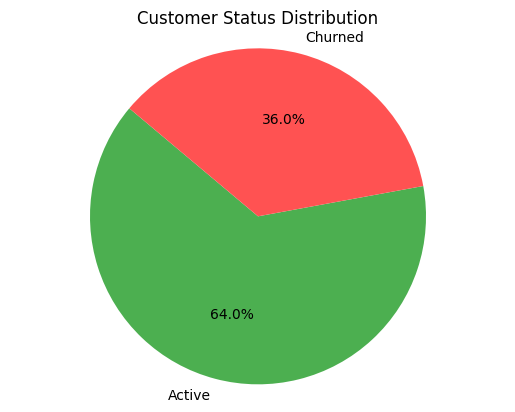

In [25]:
query = """
SELECT
    SUM(CASE WHEN close_date IS NULL THEN 1 ELSE 0 END) AS active,
    SUM(CASE WHEN close_date IS NOT NULL THEN 1 ELSE 0 END) AS churned
FROM accounts
"""
pie_df = pd.read_sql_query(query, conn)

import matplotlib.pyplot as plt

labels = ['Active', 'Churned']
sizes = [pie_df['active'][0], pie_df['churned'][0]]
colors = ['#4CAF50', '#FF5252']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Customer Status Distribution")
plt.axis('equal')
plt.show()


## ***Accounts Opened vs Churned by Year***

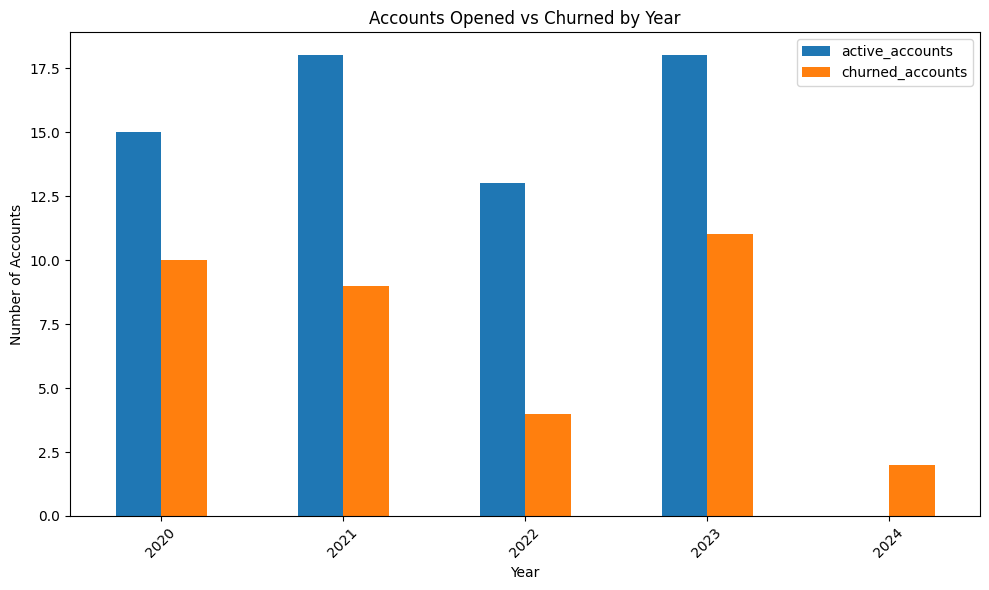

In [26]:
query = """
SELECT
    STRFTIME('%Y', open_date) AS year_opened,
    COUNT(*) AS total_accounts,
    SUM(CASE WHEN close_date IS NULL THEN 1 ELSE 0 END) AS active_accounts,
    SUM(CASE WHEN close_date IS NOT NULL THEN 1 ELSE 0 END) AS churned_accounts
FROM accounts
GROUP BY year_opened
ORDER BY year_opened
"""
year_df = pd.read_sql_query(query, conn)

year_df.plot(x='year_opened', y=['active_accounts', 'churned_accounts'], kind='bar', figsize=(10, 6))
plt.title('Accounts Opened vs Churned by Year')
plt.ylabel('Number of Accounts')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **How does churn vary by year or account type?**

In [34]:
query = """ SELECT
    account_type,
    COUNT(*) AS total_accounts,
    SUM(CASE WHEN close_date IS NOT NULL THEN 1 ELSE 0 END) AS churned_accounts,
    ROUND(SUM(CASE WHEN close_date IS NOT NULL THEN 1 ELSE 0 END)*100.0 / COUNT(*), 2) AS churn_rate
FROM accounts
GROUP BY account_type
 """
result = pd.read_sql_query(query, conn)
result


,account_type,total_accounts,churned_accounts,churn_rate
0,Current,51,18,35.29
1,Savings,49,18,36.73


## ***Customer Lifetime in Months***

In [29]:
avg_lifetime = lifetime_df['lifetime_months'].mean()
print(f"Average Customer Lifetime: {avg_lifetime:.2f} months")


Average Customer Lifetime: 35.41 months


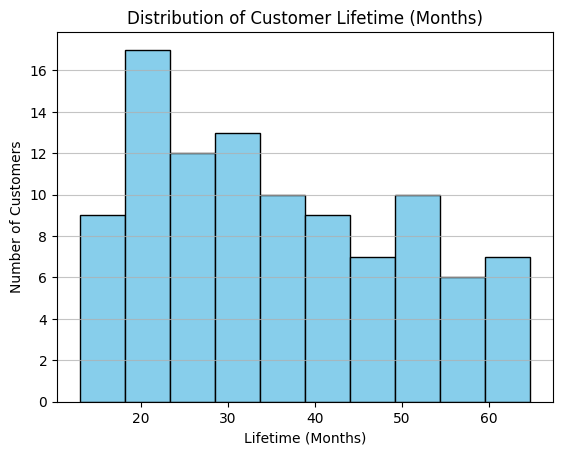

In [27]:
query = """
SELECT
    ROUND((JULIANDAY(COALESCE(a.close_date, DATE('now'))) - JULIANDAY(c.join_date)) / 30.0, 1) AS lifetime_months
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
"""
lifetime_df = pd.read_sql_query(query, conn)

plt.hist(lifetime_df['lifetime_months'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Customer Lifetime (Months)")
plt.xlabel("Lifetime (Months)")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.75)
plt.show()


## **Inactive customers who are likely to churn**



Customers with no activity in the last 3 months

In [32]:
query = """ SELECT
    a.customer_id,
    MAX(t.transaction_date) AS last_activity_date,
    ROUND(JULIANDAY(DATE('now')) - JULIANDAY(MAX(t.transaction_date))) AS days_since_last_txn
FROM accounts a
LEFT JOIN transactions t ON a.account_id = t.account_id
WHERE a.close_date IS NULL
GROUP BY a.customer_id
HAVING days_since_last_txn > 90

 """
result = pd.read_sql_query(query, conn)
result


,customer_id,last_activity_date,days_since_last_txn
0,1,2024-05-21 00:00:00,356.0
1,2,2024-11-26 00:00:00,167.0
2,4,2025-01-09 00:00:00,123.0
3,5,2023-08-17 00:00:00,634.0
4,7,2024-07-31 00:00:00,285.0
5,9,2024-11-28 00:00:00,165.0
6,11,2024-09-26 00:00:00,228.0
7,13,2025-02-03 00:00:00,98.0
8,15,2024-09-10 00:00:00,244.0
9,17,2024-05-27 00:00:00,350.0


**Key Insights**

- **Churn Rate:** Approximately **36%** of customers have closed their accounts.
- **Customer Lifetime:** The average customer stays with the bank for **35.41 months**.
- **Activity vs Retention:** Customers with frequent deposits and transactions are more likely to remain active.
- **Account Type Behavior:** Savings accounts showed slightly better retention than current accounts.


**Conclusion**

This analysis of customer churn at the bank revealed several key insights:

- The churn rate is moderate, suggesting that while many customers are loyal, there is room to improve retention strategies.

- Customers who remain active tend to transact more frequently, especially with deposits. This highlights the importance of promoting engagement through personalized banking services or rewards.

- A notable percentage of currently active customers have not transacted in over 90 days, placing them at high risk of churn. These customers can be targeted with re-engagement campaigns.

- Savings accounts showed slightly better retention than current accounts, which may indicate differing customer behaviors or product satisfaction levels.


By identifying patterns in transaction behavior and customer lifecycles,  more targeted retention strategies can be developed and ultimately reduce churn.